/Users/lakshmikc/opt/anaconda3/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+100=100. 
  warnings.warn("The balance properties of Sobol' points require "


empty fields: -64


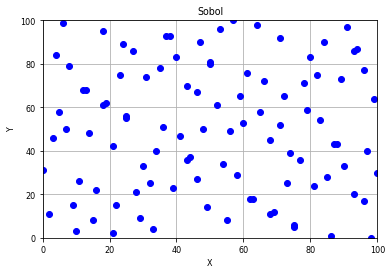

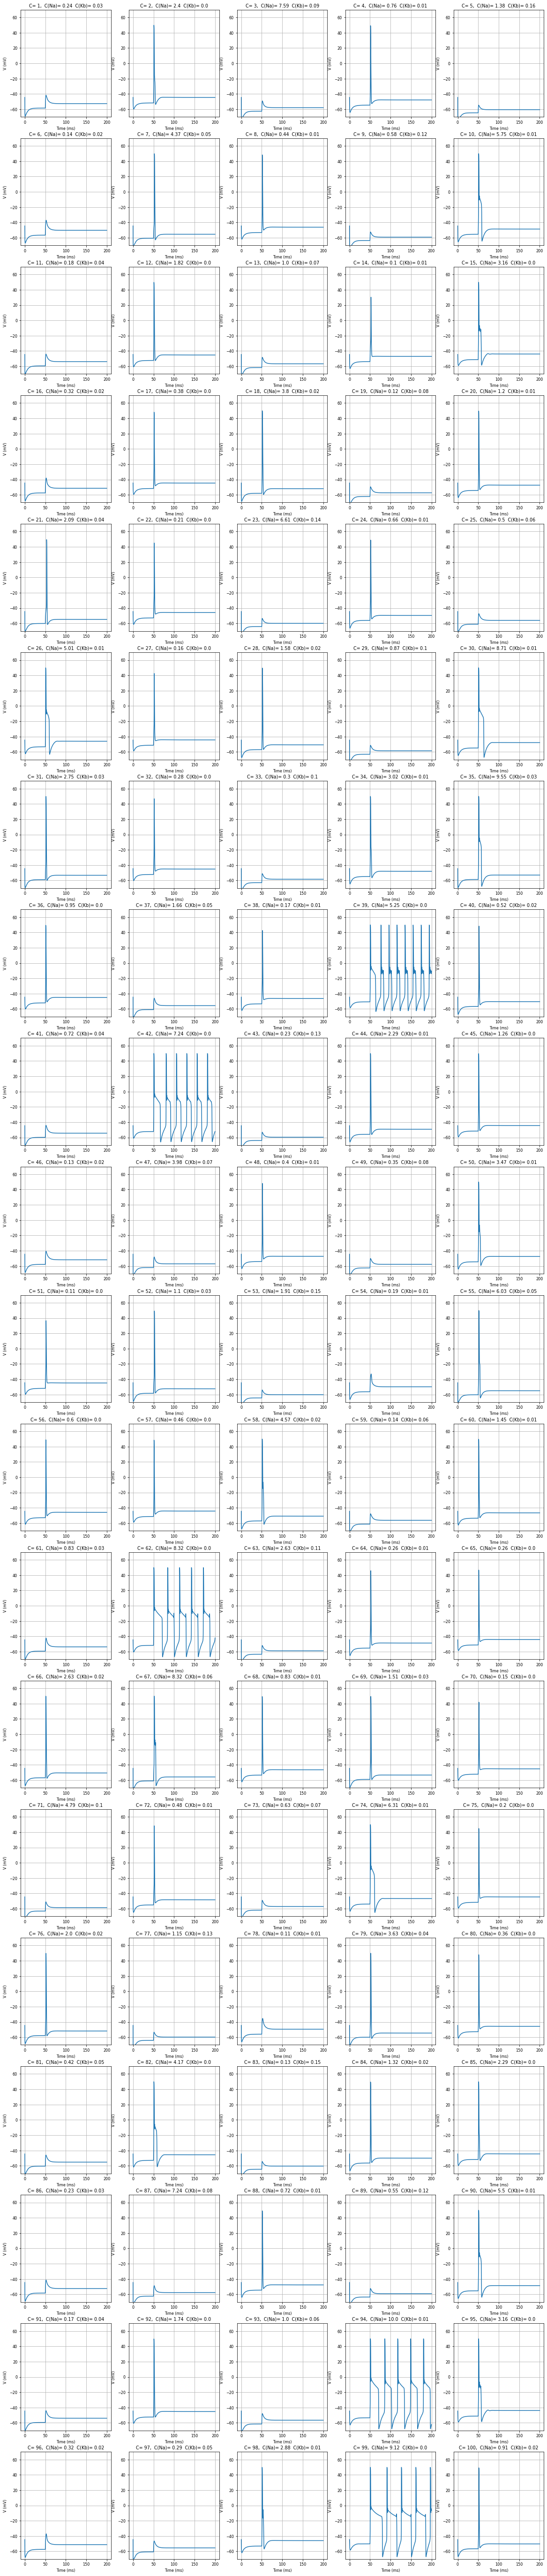

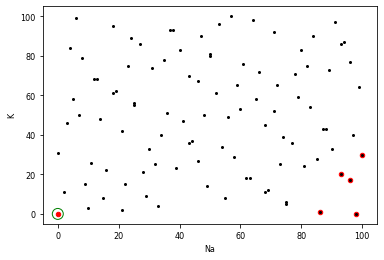

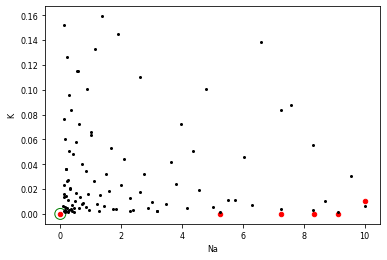

In [197]:
from neuron import h
from neuron.units import ms, mV

import math 
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import csv
import os.path

from skopt.space import Space
from skopt.sampler import Sobol
from scipy.spatial.distance import pdist
np.random.seed(1234)

h.load_file('stdrun.hoc')
h.v_init = -44.5*mV			#need to revisit - is it -44.5 mV?

soma = h.Section(name='soma')
soma.L, soma.diam, soma.cm, soma.nseg = 30, 30, 1, 1

soma.insert('pas')
soma(0.5).pas.e = h.v_init

#Channel conductances
#=====================

#Channels to vary
#########################
#Sodium channel
soma.insert('ch_Scn1a_md264834') #add channel suffix here

#Potassium channel
soma.insert('ch_Kcna1_md232813') #add channel suffix here
#########################

soma.insert('ch_Kcna1ab1_md80769') #add channel suffix here
soma.insert('ch_Kcnc1_md74298') #add channel suffix here

#Calcium channels
soma.insert('ch_Cacna1i_cp42') #add channel suffix here

soma.psection()

v = h.Vector().record(soma(0.5)._ref_v)             # membrane potential vector
t = h.Vector().record(h._ref_t)                     # timestamp vector


#EDIT THIS PART!!!!!
########################################
path1 = '/Users/lakshmikc/Dropbox (SBG)/SPARC-2020/EP-Modeling/RAGP-Models/RAGP-PyN/Cell-405/SOBOL-Na-K/DATA/'
path2 = '/Users/lakshmikc/Dropbox (SBG)/SPARC-2020/EP-Modeling/RAGP-Models/RAGP-PyN/Cell-405/SOBOL-Na-K/PLOTS/'

iclamp = h.IClamp(soma(0.5))
iclamp.delay = 50 #ms
iclamp.dur = 200.0 #ms

soma(0.5).ch_Scn1a_md264834.gNav11bar = 1.0 #0.00001
soma(0.5).ch_Kcna1_md232813.gkcnabar= 0.01592
soma(0.5).ch_Kcna1ab1_md80769.gbar = 0.011
soma(0.5).ch_Kcnc1_md74298.gk = 0.015
soma(0.5).ch_Cacna1i_cp42.gCav3_3bar = 0.00001

########################################


#Create Sobol sampling for 2  channels
######################################
def plot_searchspace(x, title):
    fig, ax = plt.subplots()
    plt.plot(np.array(x)[:, 0], np.array(x)[:, 1], 'bo', label='samples')
    #plt.plot(np.array(x)[:, 0], np.array(x)[:, 1], 'bs', markersize=40, alpha=0.5)
    # ax.legend(loc="best", numpoints=1)
    ax.set_xlabel("X")
    ax.set_xlim([0, 100])
    ax.set_ylabel("Y")
    ax.set_ylim([0, 100])
    plt.title(title)
    ax.grid(True)
    

n_samples = 100  # No pf samples
space = Space([(0, 100), (0, 100)]) #Dimension of sample space

sobol = Sobol()
pdist_data = []
x = sobol.generate(space.dimensions, n_samples)
plot_searchspace(x, 'Sobol')
filename ='Sobol-dist.png'
filename = os.path.join(path2, filename)
plt.savefig(filename)
print("empty fields: %d" % (36 - np.size(np.unique(x, axis=0), 0)))
a1 = np.array(x)[:, 0] 
b1 = np.array(x)[:, 1]
Na = (10**((a1-50)/50))
K= (10**((b1-50)/50))
pdist_data.append(pdist(x).flatten())
#x_label.append("sobol")
 
       
    
#SAVE DATA FILE AND PLOT FOR EACH CONDUCTRANCE - 
###############################################
a = 20  # number of rows
b = 5  # number of columns
c = 1  # initialize plot counter
fig = plt.figure(figsize=(20,100))


#EDIT THIS PART!!!!!
########################################
channel = "Nav2-Kcna1"
cond1 = soma(0.5).ch_Scn1a_md264834.gNav11bar
cond2 = soma(0.5).ch_Kcna1_md232813.gkcnabar

aparray1=[(0,0)]
aparray2=[(0,0)]
sparray1=[(0,0)]
sparray2=[(0,0)]


for x, y in zip(a1, b1):
    
    soma(0.5).ch_Scn1a_md264834.gNav11bar = (10**((x-50)/50))*cond1
    soma(0.5).ch_Kcna1_md232813.gkcnabar = (10**((y-50)/50))*cond2
    Na_C = round(soma(0.5).ch_Scn1a_md264834.gNav11bar,2)
    Ka_C = round(soma(0.5).ch_Kcna1_md232813.gkcnabar,2)
    #print (soma(0.5).ch_Scn1a_md264834.gNav11bar, soma(0.5).ch_Kcna1_md232813.gkcnabar)
    
#########################################    
    
    mylist2 = [1]  #Current strength
    plt.subplot(a, b, c)
    plt.rcParams.update({'font.size': 8}) 
    plt.title('C= {}'.format(c)+ ',  C(Na)= %s' %Na_C + '  C(Kb)= %s' %Ka_C)
    plt.ylim((-70,70))
    plt.xlabel("Time (ms)")
    plt.ylabel("V (mV)")    
    plt.grid(True)
    #plt.autoscale(enable=True)
    
    for iclamp.amp in mylist2: 
       
        ## RUN SIMULATION
        h.finitialize(h.v_init)
        # continue sim thru 200 ms
        h.continuerun(200 * ms)
            
        f = '%s-C%s.txt' % (channel,c)
        f = os.path.join(path1, f)
        with open(f, "w") as f:
            csv.writer(f).writerows(zip(t, v))
        plt.plot(t, v)
        
        
        AP = False
        counter = 0
        for x1, y1 in zip(t, v):   
            if ((y1> 0) and (x1 >170 )): # If action potential     
                aparray1.append((x,y))
                aparray2.append((Na_C,Ka_C))
                AP = True
                break
                      
        SP = False
        for x1, y1 in zip(t, v):  
            if ((x1< 50) and (y1>0)): #If spontaneous action potential 
                sparray1.append((x,y))
                sparray2.append((Na_C,Ka_C))
                SP = True
                break
            else:
                continue
        
                    
    c = c+1


filename ='%s.png' % (channel)
filename = os.path.join(path2, filename)
plt.savefig(filename,dpi=300, bbox_inches="tight")  
plt.show()
 

ap_vals1 = np.vstack(aparray1)
sp_vals1 = np.vstack(sparray1)

ap_vals2 = np.vstack(aparray2)
sp_vals2 = np.vstack(sparray2)

#PLOTTING THE SAMPLE SPACE
plt.scatter(ap_vals1[:,0], ap_vals1[:,1], s=20, c='red')
plt.scatter(sp_vals1[:,0], sp_vals1[:,1],s=120, facecolors='none', edgecolors='green')

filename ='NaK-dist.png'
filename = os.path.join(path2, filename)
for x, y in zip(a1, b1):
    plt.plot(x,y, 'o',markersize=2, c='black')
    plt.xlabel("Na")
    plt.ylabel("K") 
    plt.rcParams.update({'font.size': 8}) 
plt.savefig(filename)
plt.show()


#PLOTIING THE ACTUAL CONDUCTANCE VALUES
filename ='NaK-cond-dist.png'
filename = os.path.join(path2, filename)

plt.scatter(ap_vals2[:,0], ap_vals2[:,1], s=20, c='red')
plt.scatter((sp_vals2[:,0]), (sp_vals2[:,1]),s=120, facecolors='none', edgecolors='green')
for x, y in zip(Na, K):
    plt.plot(x*cond1,y*cond2, 'o',markersize=2, c='black')
   
    plt.xlabel("Na")
    plt.ylabel("K") 
    plt.rcParams.update({'font.size': 8}) 
plt.savefig(filename)
plt.show()

plt.close()

